In [1]:
import numpy as np
import os
import json
from matplotlib import pyplot as plt, cm
import tensorflow as tf
import numpy as np
import cv2 as cv

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.scorecam import Scorecam

# # clone the repository, if it doesnt exist already
# try:
#     from transforms.apply_patch import ApplyPatch
# except:
#     # clone the repository
#     !git clone https://github.com/pralab/ImageNet-Patch
        
from inpaint import inpaint

In [2]:
# Load model
Model = ResNet50
model = Model(weights='imagenet')

# global parameters
ROOT_DIR = os.getcwd()
CURR_DIR = os.getcwd()

# Download the json file of list of classes in imagenet with index
if os.path.isfile('imagenet_class_index.json') == False:
    !wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel  = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])

In [3]:
def cnv_lst_arr(lst):
    ''' Convert list object to array. '''
    arr = np.array(lst)
    return arr

def reset_dir():
    ''' Change the directory to root directory of project. '''
    os.chdir(ROOT_DIR)
    CURR_DIR = os.getcwd()

def change_dir(dir):
    '''
    Change the directory to specified directory.

    Args:
        dir: The directory where to set the cwd
    '''
    os.chdir(dir)
    CURR_DIR = os.getcwd()

In [17]:
def attack_accuracy(self):
    '''
    Find the clean accuracy, robust accuracy and attack success rate
    '''
    # test model with clean image
    # find clean accuracy
    # find no. of clean img classified correctly

    # find model with adv image
    # find the adv accuracy
    # find no. of adv img targetted correctly

    # find total no. of samples

    # clean_accuracy = 100*(correct_clean / n_samples)
    # robust_accuracy = 100*(correct_adv / n_samples)
    # success_rate = 100*(n_success / n_samples)

class inpaint_defense:
    def __init__(self, model, classlabel):
        '''
        Args:
            model: The model for predictions
            classlabel: The class label for 1000 classes
            images: The batch of images that we are working with [?, 224, 224, 3]
            orig_predictions: The array of predictions for the original input image [?, index, class]
            new_predictions: The array of predictions after inpainting the input image [?, index, class]
            orig_class_lbls: The index of each class the original image belongs to
            new_class_lbls: The index of each class the inpainted image belongs to
            cams: The batch of cam filter obtained for each image [?, 224, 224]
            patch_mask: The patch mask generated using a threshold value (0.5) [?, 224, 224]
            inpaint_images: The batch of images obtained after applying inpainting [?, 224, 224, 3]
        '''
        self.model = model
        self.batch_size = 0
        self.classlabel = classlabel
        self.images = []
        self.orig_predictions = []
        self.new_predictions = []
        self.orig_class_lbls = []
        self.new_class_lbls = []
        self.cams = []
        self.patch_masks = []
        self.inpaint_images = []
        
    def load_dataset(self, directory, img_per_class=2, show_plot=False):
        '''
        Load the dataset from given directory.

        Args:
            directory: A directory that contains folder for every class the image belongs to
            img_per_class: The number of images to display for each class (defaults to 2)
            show_plot: a boolean variable to determine whether to display the plots of images(default, True)
        '''
        try:
            change_dir(directory)

            for ind, file in enumerate(os.listdir()):

                # go to the dataset directory
                change_dir(file)
                for ind, file in enumerate(os.listdir()):
                    if ind == img_per_class:
                            break

                    if file.endswith('.JPEG') | file.endswith('.jpg'):
                        # Load the image and convert BGR-> RGB
                        # img = cv.imread(file)
                        # img = cv.resize(img, (224, 224))
                        # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                        img = load_img(file, target_size=(224, 224, 3))
                        img = img_to_array(img).astype(np.uint8)

                        self.images.append(img.copy())
                        img = np.expand_dims(img, axis=0)

                        tmp_img = preprocess_input(img.copy())
                        img_pred = model.predict(tmp_img)
                        prediction = decode_predictions(img_pred, top=1)

                        class_lbl = classlabel.index(prediction[0][0][1])

                        self.orig_predictions.append(prediction[0][0])
                        self.orig_class_lbls.append(class_lbl)
                        self.batch_size += 1

                        if show_plot == True:
                            self.plot_images(img)

                # Go back previous directory to change directory of image class
                change_dir('..')

            # Convert all the list to array elements
            self.images = cnv_lst_arr(self.images)
            self.orig_predictions = cnv_lst_arr(self.orig_predictions)
            self.orig_class_lbls = cnv_lst_arr(self.orig_class_lbls)
            reset_dir()
        except Exception as e:
            print(e)
            reset_dir()


    def grad_plot(self, cam, title, heatmap, index):
        '''
        Plot a graph of saliency feature generate through gradCAM.
        
        Args:
            cam: The gradcam object which generates the heatmap
            title: The title of the saliency plot
            heatmap: The heatmap that we generated using gradcam object
            index: The index of the saliency plot for respective image
        '''
        plt.title(title, fontsize=16)
        plt.imshow(np.uint8(self.images[index]))
        plt.imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def grad_cam(self, show_plot=False):
        '''
        Generates the saliency map of the given batch of images usning gradient CAM technique.
        
        Args:
            show_plot: a boolean variable to determine whether to display the saliency map for each image(default, True)
        '''
        # When the softmax activation function is applied to the last layer of model,
        # it may obstruct generating the attention images, so you should replace the function to a linear activation function.

        replace2linear = ReplaceToLinear()

        # # Instead of using the ReplaceToLinear instance above,
        # # you can also define the function from scratch as follows:
        # def model_modifier_function(cloned_model):
        #     cloned_model.layers[-1].activation = tf.keras.activations.linear

        # And then, you MUST create Score instance or define score function that returns target scores.
        # Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.

        score = CategoricalScore(self.orig_class_lbls.tolist())

        image_titles = self.orig_predictions[:, 1]

        # Create Gradcam object
        gradcam = Gradcam(self.model, model_modifier=replace2linear, clone=True)
        
        # Create Scorecam object
        scorecam = Scorecam(model, model_modifier=replace2linear)

        # # Generate heatmap with GradCAM
        # cam = gradcam(score, (np.float32(self.images)).copy(), penultimate_layer=-1)
        
        # Generate heatmap with Faster-ScoreCAM
        cam = scorecam(score, (np.float32(self.images)).copy(), penultimate_layer=-1, max_N=10)

        for i, title in enumerate(image_titles):
            heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
            
            if show_plot == True:
                self.grad_plot(cam, title, heatmap, i)
            
            self.cams.append(cam[i].copy())

        self.cams = cnv_lst_arr(self.cams)
    
    def mask_plot(self, img):
        '''
        Function that plots the mask generated for the image.
        Args:
            img: The mask image to print
        '''
        plt.imshow(np.uint8(img), cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def gen_mask(self, show_plot=False):
        ''' Generates a binary mask from saliency map obtained for every image in the given batch.'''
        
        _, x_size, y_size, _ = self.images.shape
        
        for ind in range(self.cams.shape[0]):
            
            temp_cam = self.cams[ind].copy()
            
            # binary_patch_mask = np.zeros([x_size, y_size], np.uint8)
            # binary_patch_mask = np.where(temp_cam >= 0.5, 1., binary_patch_mask)
            # binary_patch_mask = binary_patch_mask.astype(bool, copy=False)            
            
            binary_patch_mask = []
            binary_patch_mask = np.where(temp_cam >= 0.5, 1., 0.) # 1. - (temp_cam.mean())
            
            self.patch_masks.append(np.array(binary_patch_mask))
        
            if show_plot == True:
                self.mask_plot(binary_patch_mask)

        self.patch_masks = cnv_lst_arr(self.patch_masks)

    def apply_inpaint(self, show_plot=False):
        '''
        Applies inpainting technique toremove adversarial patch from the images in the given batch.
        Also gives a plot of images obtained after inpainting along with class predictions
        
        Args:
            show_plot: a boolean variable to determine whether to show plot of new prediction obtained after applying inpainting technique(default, True)
        '''
        for ind in range(self.images.shape[0]):
            
            inpaint_img = (self.images[ind]).copy()
            
            src_img = inpaint_img
            img = inpaint_img
            mask = self.patch_masks[ind]

            inpaint_img = inpaint(src_img, img, mask)
            
            self.inpaint_images.append(inpaint_img)
            
            inpaint_img = np.expand_dims(inpaint_img.copy(), axis=0)
            
            # Find new predictions after inpainting
            tmp_img = preprocess_input(inpaint_img.copy())
            img_pred = model.predict(tmp_img)
            prediction = decode_predictions(img_pred, top=1)
            class_lbl = classlabel.index(prediction[0][0][1])
            
            self.new_predictions.append(prediction[0][0])
            self.new_class_lbls.append(class_lbl)
            
            if show_plot == True:
                self.plot_images(inpaint_img)

        # Convert all the list to array elements
        self.inpaint_images = cnv_lst_arr(self.inpaint_images)
        self.new_predictions = cnv_lst_arr(self.new_predictions)
        self.new_class_lbls = cnv_lst_arr(self.new_class_lbls)

    
    def plot_images(self, img):
        '''
        Plot the image with title as the prediction class, confidence and its class label.
        Args:
            img: The imaeg to be plotted [1, 224, 224, 3]
        '''
         # Find new predictions after inpainting
        tmp_img = preprocess_input(img.copy())
        img_pred = model.predict(tmp_img)
        prediction = decode_predictions(img_pred, top=1)
        class_lbl = classlabel.index(prediction[0][0][1])

        # Rendering
        plt.figure(figsize=(3, 4))
        plt.title(f'Prediction: {prediction[0][0][1]}({prediction[0][0][2]:1.3})\nLabel: {class_lbl}')
        plt.imshow(np.uint8(img[0]))
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def generate_inpaint(self, grad_flag=False, mask_flag=False, inpaint_flag=False):
        '''
        A function that performs the given tasks in sequential order. 
        Args:
            grad_plot: Indicates if we want to display the plot of gradient cam
            mask_flag: Indicates if we want to display the plot of mask obtained
            inpaint_flag: Indicates if we want to display the plot of inapint images
        '''
        # After loading od fata is done, generate its saliency map using grad CAM technique
        self.grad_cam(show_plot=grad_flag)
        
        # genearate a mask by setting a threshold value 
        self.gen_mask(show_plot=mask_flag)
        
        # Apply inpainting technique and get predictions for class
        self.apply_inpaint(show_plot=inpaint_flag)

    def plot_data(self, index):
        '''
        Plots the graph of following:
            1. Original image
            2. Its heatmap generated using Scorecam
            3. The binary mask generated from the heatmap
            4. The final image after applying inpainting technique
        Args:
            index: The index of the image to print the plots
        '''
        fig, axes = plt.subplots(1, 4, figsize=(12, 7))
        fig.tight_layout()

        axes[0].imshow(self.images[index])
        axes[0].set_title(f'Prediction: {self.orig_predictions[index][1]}({self.orig_predictions[index][2]:1.3})\nLabel: {self.orig_class_lbls[index]}')
        axes[0].axis('off')
        
        axes[1].imshow(self.cams[index])
        axes[1].set_title('Heatmap of salient feature')
        axes[1].axis('off')
        
        axes[2].imshow(self.patch_masks[index], cmap='gray')
        axes[2].set_title('Binary mask for inpainting')
        axes[2].axis('off')
        
        axes[3].imshow(self.inpaint_images[index])
        axes[3].set_title(f'Prediction: {self.new_predictions[index][1]}({self.new_predictions[index][2]:1.3})\nLabel: {self.new_class_lbls[index]}')
        axes[3].axis('off')
        plt.show()

## Testing on 2 images

In [5]:
id_test = inpaint_defense(model, classlabel)
id_test.load_dataset('test_data')

1/1 [==============================] - 0s 144ms/step


In [6]:
id_test.generate_inpaint()

1/1 [==============================] - 0s 139ms/step


C:\Users\rohan\AppData\Local\Temp\ipykernel_10284\4208943261.py:298: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


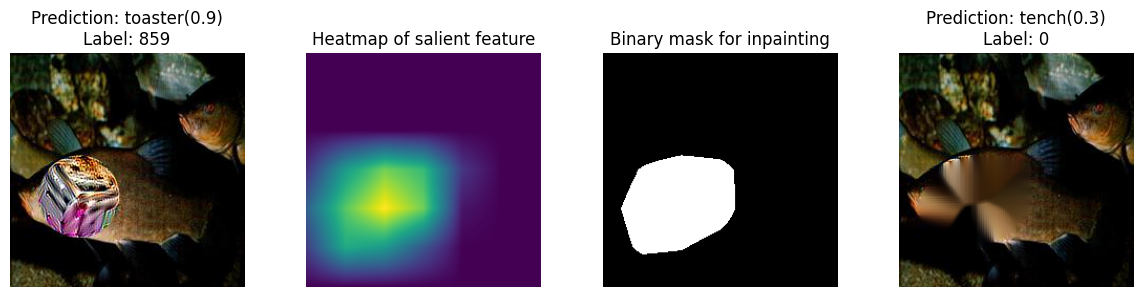

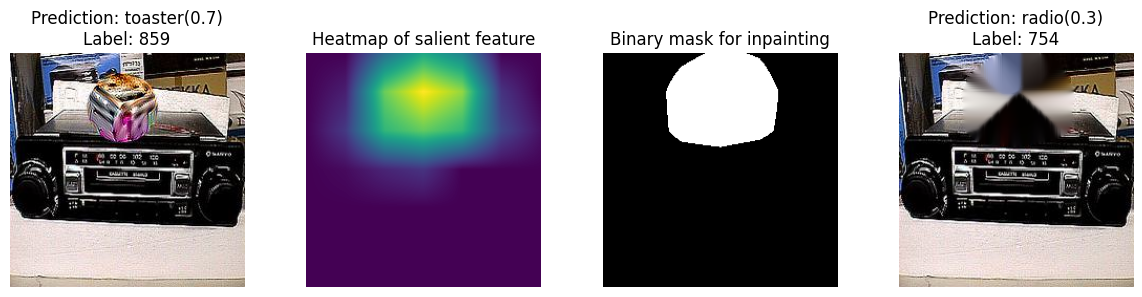

In [7]:
for i in range(id_test.batch_size):
    id_test.plot_data(i)
    plt.sh

## Clean image dataset of 50 images

In [8]:
# id1 = inpaint_defense(model, classlabel)
# id1.load_dataset('dataset_clean')

In [9]:
# id1.generate_inpaint()

In [10]:
# for i in range(id1.batch_size):
#     print(i)
#     id1.plot_adjacent(i)

## Patched image dataset (0.30 scale)

In [11]:
# id2 = inpaint_defense(model, classlabel)
# id2.load_dataset('dataset_adv_x.30')

In [12]:
# id2.execute_in_order(grad_flag=True, mask_flag=True, inpaint_flag=True)

In [13]:
# for i in range(id2.batch_size):
#     print(i)
#     id2.plot_adjacent(i)

## Patched image dataset (0.35 scale)

In [14]:
# id3 = inpaint_defense(model, classlabel)
# id3.load_dataset('dataset_adv_x.35')

In [15]:
# id3.execute_in_order()

In [16]:
# for i in range(id3.batch_size):
#     print(i)
#     id3.plot_adjacent(i)